In [1]:
# preamble
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

### We're going to start off looking at the job prestige data set from the lecture.

prestige.csv contains information about various jobs. Let's load the data

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/sinead/DS32019/master/data/prestige.csv")
df.head()

,Unnamed: 0,education,income,women,prestige,census,type
0,gov.administrators,13.11,12351,11.16,68.8,1113,prof
1,general.managers,12.26,25879,4.02,69.1,1130,prof
2,accountants,12.77,9271,15.70,63.4,1171,prof
3,purchasing.officers,11.42,8865,9.11,56.8,1175,prof
4,chemists,14.62,8403,11.68,73.5,2111,prof


### Let's build a linear regression model predicting prestige, from income and profession type. 

(We're ignoring the other variables just to make plotting the results easier)

We'll start by introducing dummies for type.

In [3]:
print('unique types: {}'.format(df.type.unique()))
df = pd.concat([df, pd.get_dummies(df['type'])], axis=1)
df.head()

unique types: ['prof' 'bc' 'wc' nan]


,Unnamed: 0,education,income,women,prestige,census,type,bc,prof,wc
0,gov.administrators,13.11,12351,11.16,68.8,1113,prof,0,1,0
1,general.managers,12.26,25879,4.02,69.1,1130,prof,0,1,0
2,accountants,12.77,9271,15.70,63.4,1171,prof,0,1,0
3,purchasing.officers,11.42,8865,9.11,56.8,1175,prof,0,1,0
4,chemists,14.62,8403,11.68,73.5,2111,prof,0,1,0


### Let's also scale the data so income and education are standardized... 
it'll make it easier to come up with decent priors 

In [4]:
df['income_z'] = (df['income'] - np.mean(df['income'])) / (np.std(df['income']))

df['prestige_z'] = (df['prestige'] - np.mean(df['prestige'])) / (np.std(df['prestige']))

### Let's quickly visualize the data

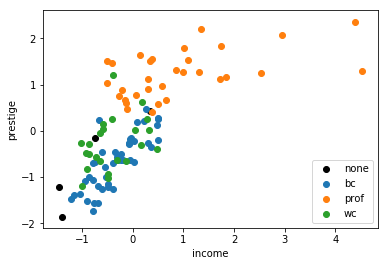

In [5]:
categories = ['bc', 'prof', 'wc']
colors =['C0', 'C1', 'C2']

# first draw the nan professions:
df_tmp = df[pd.isnull(df.type)]
plt.scatter(x=df_tmp['income_z'], y=df_tmp['prestige_z'], color='black', label='none')

#then iterate through the other professions
for i in range(3):
    df_tmp = df[df.type == categories[i]]
    plt.scatter(x=df_tmp['income_z'], y=df_tmp['prestige_z'], 
                color=colors[i], label=categories[i])
    
plt.xlabel('income')
plt.ylabel('prestige')
plt.legend()
plt.show()

### On to some stats! Let's start with the OLS estimator

We're going to use 

We know that $\hat{\beta}_{LS} = (X^TX)^{-1}X^Ty$

Edit the code below to implement the OLS estimator, then test it out in the next cell.
<br>
Helpful snippet: to calculate $\hat{x} = A^{-1}b$, you can use numpy's least squares solver: 

`x_est = np.linalg.lstsq(A, b)[0]`

In [6]:
def least_squares(X, y):
    '''X is an N x D array, y is a length-N vector. Should return a D-dimensional vector'''
    #est = # TO DO
    A = np.dot(X.T, X)

    b = np.dot(X.T, y)

    est = np.linalg.lstsq(A, b, rcond=None)[0] # solves x = A^{-1} b
    
    return est

In [7]:
# Build X and y - don't forget the intercept!
N = len(df)
D = 4 # income plus three dummies
X = np.ones((N, D + 1))
X[:, 1:] = df[['income_z', 'bc', 'prof', 'wc']]

y = df['prestige_z']

# Now, construct the least squares estimator:
beta_hat_LS = least_squares(X, y)


print('least squares estimates:\n')
print('intercept: \t{:.4f}\nbc: \t\t{:.4f}\nprof: \t\t{:.4f}\nwc: \t\t{:.4f}'.format(beta_hat_LS[0],
                                                                                     beta_hat_LS[1],
                                                                                     beta_hat_LS[2],
                                                                                     beta_hat_LS[3]
                                                                                    ))
               

least squares estimates:

intercept: 	-0.4045
bc: 		0.3705
prof: 		-0.1311
wc: 		1.3021


### Now let's plot the resulting lines

In [8]:
#here's some code to draw lines

def add_line(intercept, slope, linetype='--', color='black', alpha=1., label=None):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    axes.set_xlim()
    axes.set_ylim()
    x_vals = np.array(axes.get_xlim())
    
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, linetype, color=color, label=label, alpha=alpha)

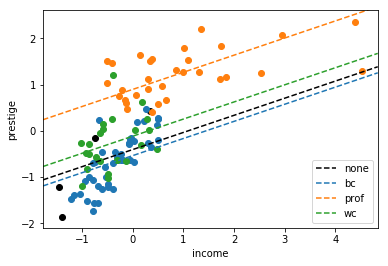

In [9]:
# first plot the scatter plots, as before:
df_tmp = df[pd.isnull(df.type)]
plt.scatter(x=df_tmp['income_z'], y=df_tmp['prestige_z'], color='black', label=None)

for i in range(3):
    df_tmp = df[df.type == categories[i]]
    plt.scatter(x=df_tmp['income_z'], y=df_tmp['prestige_z'], color=colors[i], label=None)

# Then add in the lines

# First add in the null line: 
add_line(beta_hat_LS[0], beta_hat_LS[1], color='black', label='none')

# Then add in the other profession lines: 
for i in range(3):
    add_line(beta_hat_LS[0] + beta_hat_LS[2 + i], beta_hat_LS[1], 
             color=colors[i], label=categories[i])
    
plt.xlabel('income')
plt.ylabel('prestige')
plt.legend()
plt.show()

### Bonus question - how could we improve this model? Try getting a least squares estimate of a more complex model.

## Now, let's compare with ridge regression.

Recall that the ridge regression estimator takes the form

$$\hat{\beta}_{ridge} = \left(X^TX + \lambda \mathbf{I}\right)^{-1}X^Ty$$

In the cell below, write a function to estimate $\hat{\beta}_{ridge}$.

In the next cell, ick a value for $\lambda$, test your code.
    
    

In [10]:
def ridge(X, y, lambda_param):
    '''
    X is an N x D array, y is a length-N vector, lambda_param is a float. 
    Should return a D-dimensional vector.
    '''
    #est = # TODO
    est = np.linalg.lstsq(np.dot(X.T, X) + lambda_param * np.eye(D + 1), np.dot(X.T, y), rcond=None)[0]

    return est

In [11]:
lambda_param = 1.# pick a value

beta_hat_ridge = ridge(X, y, lambda_param)

print('parameter \t least squares \t ridge')

print('intercept \t {:.4f} \t {:.4f}'.format(beta_hat_LS[0], beta_hat_ridge[0]))
print('bc \t\t {:.4f} \t {:.4f}'.format(beta_hat_LS[1], beta_hat_ridge[1]))
print('prof \t\t {:.4f} \t {:.4f}'.format(beta_hat_LS[2], beta_hat_ridge[2]))
print('wc \t\t {:.4f} \t {:.4f}'.format(beta_hat_LS[3], beta_hat_ridge[3]))


parameter 	 least squares 	 ridge
intercept 	 -0.4045 	 -0.1668
bc 		 0.3705 	 0.3907
prof 		 -0.1311 	 -0.3539
wc 		 1.3021 	 1.0138


### Plot and compare with the least squares values. 


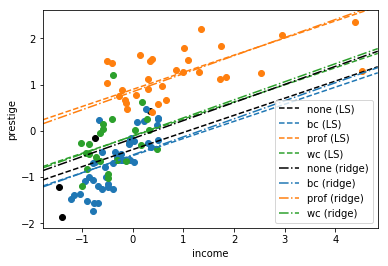

In [12]:
# first plot the scatter plots, as before:
df_tmp = df[pd.isnull(df.type)]
plt.scatter(x=df_tmp['income_z'], y=df_tmp['prestige_z'], color='black', label=None)

for i in range(3):
    df_tmp = df[df.type == categories[i]]
    plt.scatter(x=df_tmp['income_z'], y=df_tmp['prestige_z'], color=colors[i], label=None)
    

# Then add in the lines

# first the old lines:
add_line(beta_hat_LS[0], beta_hat_LS[1], color='black', label='none (LS)')
for i in range(3):
    add_line(beta_hat_LS[0] + beta_hat_LS[2 + i], beta_hat_LS[1], 
             color=colors[i], label='{} (LS)'.format(categories[i]))

# Then the new lines

add_line(beta_hat_ridge[0], beta_hat_ridge[1], color='black', linetype='-.', 
         label='none (ridge)')
for i in range(3):
    add_line(beta_hat_ridge[0] + beta_hat_ridge[2 + i], beta_hat_ridge[1], 
             linetype='-.', color=colors[i], label='{} (ridge)'.format(categories[i]))
    
plt.xlabel('income')
plt.ylabel('prestige')
plt.legend()
plt.show()

### Is it behaving as you'd expect?

Play around with some more values for $\lambda$

# Let's move onto Bayesian regression.

Recall that, with fixed $\sigma$ and a $\mbox{Normal}(\mu_0, \Sigma_0)$ prior on $\beta$, our posterior distribution for $\beta$ is $\mbox{Normal}(\mu_n, \Sigma_n)$ where

$$\mu_n = \left(\Sigma_0^{-1} + X^TX/\sigma^2\right)^{-1}\left(\Sigma_0^{-1}\beta_0 + X^Ty/\sigma^2\right)$$

$$\Sigma_n = \left(\Sigma_0^{-1} + X^TX/\sigma^2\right)^{-1}$$

Write some code to obtain the posterior parameters.


In [13]:
def bayes(X, y, mu_0, S_0, sigma):
    '''
    X is an N x D array, y is a length-N vector, 
    mu_0 is a D-dimensional vector, S_0 is a D x D array, sigma is a positive scalar. 
    Should return a D-dimensional vector mu_n and a D x D array S_n.
    '''
    #mu_n = # TODO
    #S_n = # TODO
    S_n = np.linalg.inv(np.linalg.inv(S_0) + np.dot(X.T, X) / (sigma ** 2))

    mu_n = np.dot(S_n, np.dot(np.linalg.inv(S_0), mu_0) + np.dot(X.T, y) / (sigma ** 2))
    return mu_n, S_n

Since we standardized our data, let's start with $\sigma^2=1$, $\mu_0 = 0$, and $\Sigma_0 = \mathbf{I}$


In [14]:
sigma = 1.
mu_0 = np.zeros(X.shape[1])
S_0 = np.eye(X.shape[1])


mu_n, S_n = bayes(X, y, mu_0, S_0, sigma)


### Compare your value of $\mu_n$ with $\hat{\beta}_{ridge}$, when $\Sigma_0 = \frac{1}{\lambda^2}\mathbf{I}$

In [15]:
lambda_comp = 1. 
beta_hat_ridge_comp = ridge(X, y, lambda_comp)

print('parameter \t Bayes mean \t ridge')

print('intercept \t {:.4f} \t {:.4f}'.format(mu_n[0], beta_hat_ridge_comp[0]))
print('bc \t\t {:.4f} \t {:.4f}'.format(mu_n[1], beta_hat_ridge_comp[1]))
print('prof \t\t {:.4f} \t {:.4f}'.format(mu_n[2], beta_hat_ridge_comp[2]))
print('wc \t\t {:.4f} \t {:.4f}'.format(mu_n[3], beta_hat_ridge_comp[3]))



parameter 	 Bayes mean 	 ridge
intercept 	 -0.1668 	 -0.1668
bc 		 0.3907 	 0.3907
prof 		 -0.3539 	 -0.3539
wc 		 1.0138 	 1.0138


### Now let's simulate from the posterior, to get an idea of what it looks like

For visual clarity, let's just look at the professional jobs

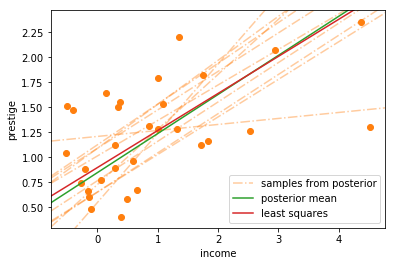

In [16]:
num_samples = 10
cat = 1 # corresponds to professional jobs

# first plot the scatter plot
df_tmp = df[df.type == categories[cat]]
plt.scatter(x=df_tmp['income_z'], y=df_tmp['prestige_z'], color='C1', label=None)

# then add in num_samples samples
for i in range(num_samples):
    mu_sample = np.random.multivariate_normal(mean=mu_n, cov=S_n)
    if i == 0:
        add_line(mu_sample[0] + mu_sample[2 + cat], mu_sample[1], 
                 linetype='-.', color='C1', alpha=0.4, label='samples from posterior')
    else:
        add_line(mu_sample[0] + mu_sample[2 + cat], mu_sample[1], 
                 linetype='-.', color='C1', alpha=0.4, label=None)
add_line(mu_n[0] + mu_n[2 + cat], mu_n[1], linetype='-', color='C2', label='posterior mean')

add_line(beta_hat_LS[0] + beta_hat_LS[2 + cat], beta_hat_LS[1], linetype='-', color='C3', label='least squares')
plt.xlabel('income')
plt.ylabel('prestige')
plt.legend()
plt.show()

## What do you expect this plot to look like as the prior changes?

Try it and find out! 

Re-run with $\mu_0 = [10,10,10,10,10]$



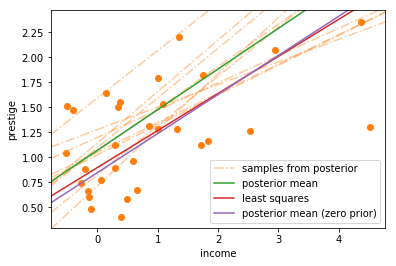

In [17]:
mu_0_ones = 10*np.ones(X.shape[1])

mu_n_ones, S_n_ones = bayes(X, y, mu_0_ones, S_0, sigma)


num_samples = 10
cat = 1 # corresponds to professional jobs

# first plot the scatter plot
df_tmp = df[df.type == categories[cat]]
plt.scatter(x=df_tmp['income_z'], y=df_tmp['prestige_z'], color='C1', label=None)

# then add in num_samples samples
for i in range(num_samples):
    mu_sample = np.random.multivariate_normal(mean=mu_n_ones, cov=S_n_ones)
    if i == 0:
        add_line(mu_sample[0] + mu_sample[2 + cat], mu_sample[1], 
                 linetype='-.', color='C1', alpha=0.4, label='samples from posterior')
    else:
        add_line(mu_sample[0] + mu_sample[2 + cat], mu_sample[1], 
                 linetype='-.', color='C1', alpha=0.4, label=None)
add_line(mu_n_ones[0] + mu_n_ones[2 + cat], mu_n_ones[1], linetype='-', color='C2', label='posterior mean')

add_line(beta_hat_LS[0] + beta_hat_LS[2 + cat], beta_hat_LS[1], linetype='-', color='C3', label='least squares')

add_line(mu_n[0] + mu_n[2 + cat], mu_n[1], linetype='-', color='C4', label='posterior mean (zero prior)')
plt.xlabel('income')
plt.ylabel('prestige')
plt.legend()
plt.show()

### What would you expect this plot to look like as the amount of data changes?


# Let's try on a different dataset

### We're going to look at a dataset of the number of publications for biochemistry PhD students

* art: articles in last three years of Ph.D.
* fem: coded one for female
* mar: coded one if married
* kid5: number of children under age six
* phd: prestige of Ph.D. program
* ment: articles by mentor in last three years

Let's load the data

In [18]:
df2 = pd.read_stata("http://www.stata-press.com/data/lf2/couart2.dta")
df2.head()

,art,fem,mar,kid5,phd,ment
0,0,0,1,0,2.52,7
1,0,1,0,0,2.05,6
2,0,1,0,0,3.75,6
3,0,0,1,1,1.18,3
4,0,1,0,0,3.75,26


### Let's look at predicting number of articles from marital status and program prestige

(I'm ignoring the other variables for now so we can easily plot the resulting model)

### We'll start with only 5 data points, and then add more data.

In [19]:
# construct the full dataset
N = len(df2)
X2 = np.ones((N, 3))
X2[:, 1:] = df2[['mar', 'phd']]
y2 = df2['art']

In [20]:

# I'm using the same priors as before, feel free to change them

sigma = 1.
mu_0 = np.zeros(X2.shape[1])
S_0 = np.eye(X2.shape[1])



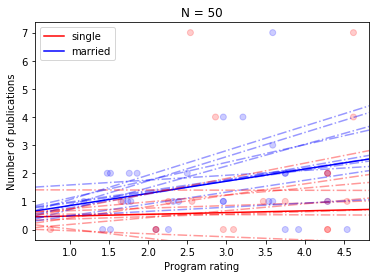

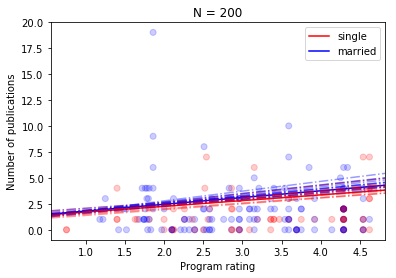

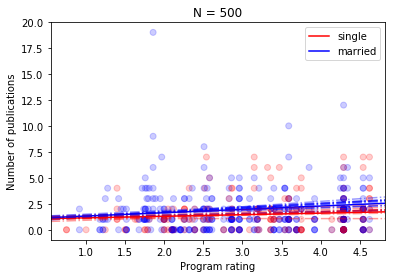

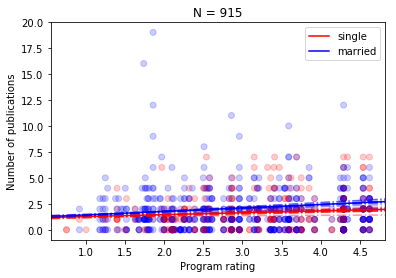

In [21]:
data_sizes = [50, 200, 500, len(y2)]
num_samples = 10
colors = np.array(['red', 'blue'])

# shuffle the rows of X2
rp = np.random.permutation(len(y2))
X2 = X2[rp, :]
y2 = y2[rp]

for n in data_sizes:
    X2_tmp = X2[:n, :]
    y2_tmp = y2[:n]
    
    ## calculate mu_n and S_n
    mu_n, S_n = bayes(X2_tmp, y2_tmp, mu_0, S_0, sigma)
     
    # plot the data, colored by marital status
    plt.scatter(x=X2_tmp[:, 2], y=y2_tmp, color=colors[X2_tmp[:, 1].astype(int)], alpha = 0.2, label=None)
    
    # plot the mean functions, colored by marital status
    
    add_line(mu_n[0], mu_n[1], linetype='-', color=colors[0], label='single')
    add_line(mu_n[0], mu_n[1] + mu_n[2], linetype='-', color=colors[1], label='married')
    
    # add in sampled lines
    for i in range(num_samples):
        mu_sample = np.random.multivariate_normal(mean=mu_n, cov=S_n)
        add_line(mu_sample[0], mu_sample[1], 
                 linetype='-.', color=colors[0], alpha=0.4, label=None)
        add_line(mu_sample[0], mu_sample[1] + mu_sample[2], 
                 linetype='-.', color=colors[1], alpha=0.4, label=None)
        
    plt.xlabel('Program rating')
    plt.ylabel('Number of publications')
    plt.legend()
    plt.title('N = {}'.format(n))
    plt.show()



### Does it look a reasonable fit?

Suggest some ways in which the model might not be the best fit for the data.

We'll work on incorporating these in the next set few slides.